# Лабораторная работа № 2.
## Выполнил студент группы ББМО-01-23 Стрыбак Вячеслав Валерьевич

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

100%|██████████| 612M/612M [00:24<00:00, 26.4MB/s]

Extracting files...


In [ ]:
import cv2
import os
import torch
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent


# Задание 1.

Извлечение изображений для создания тренировочной выборки.


In [ ]:
train_path = "Train"
labels = []
data = []
CLASSES = 43
for i in range(CLASSES):
    img_path = os.path.join(train_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)

Пример изображения из датасета

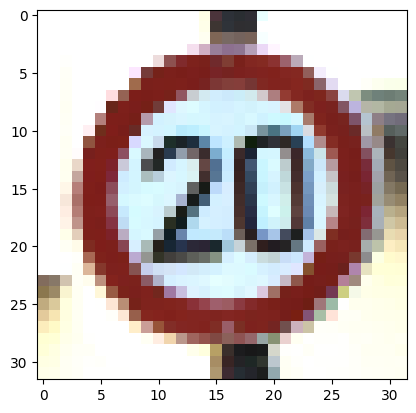

In [ ]:
plt.imshow(data[0])

## Обучение модели ResNet50

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

In [ ]:
img_size = (224,224)
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False

In [ ]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 56s 70ms/step - loss: 1.2173 - accuracy: 0.6830 - val_loss: 4.1630 - val_accuracy: 0.2711
Epoch 2/5
429/429 [==============================] - 29s 67ms/step - loss: 0.2291 - accuracy: 0.9394 - val_loss: 1.4918 - val_accuracy: 0.6410
Epoch 3/5
429/429 [==============================] - 22s 52ms/step - loss: 0.1416 - accuracy: 0.9645 - val_loss: 1.3045 - val_accuracy: 0.9082
Epoch 4/5
429/429 [==============================] - 24s 57ms/step - loss: 0.1105 - accuracy: 0.9739 - val_loss: 0.0833 - val_accuracy: 0.9777
Epoch 5/5
429/429 [==============================] - 24s 57ms/step - loss: 0.0748 - accuracy: 0.9808 - val_loss: 0.0997 - val_accuracy: 0.9724


In [ ]:
save_model(model, 'ResNet50.h5')
with open('history_ResNet50.pkl', 'wb') as file:
    pickle.dump(history.history, file)
!cp ResNet50.h5 drive/MyDrive/ResNet50.h5

<ipython-input-10-7662eceeb572>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'ResNet50.h5')


Графики точности и потерь модели ResNet50

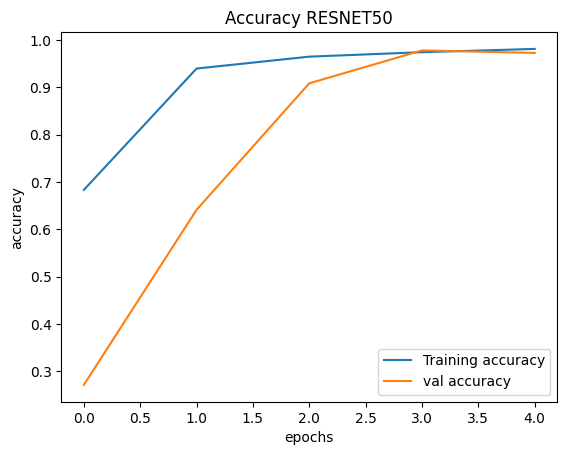

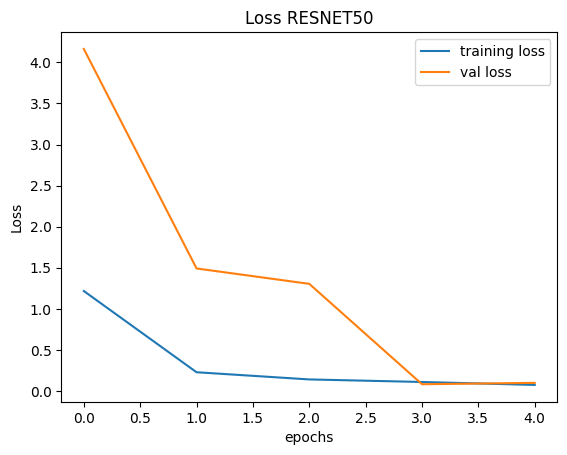

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy RESNET50")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss RESNET50")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Загрузка тестовых данных для оценки модели

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)
data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

Оценка точности модели

In [ ]:
loss, accuracy = model.evaluate(data, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

395/395 [==============================] - 7s 15ms/step - loss: 0.3321 - accuracy: 0.9230
Test loss: 0.3321272134780884
Test accuracy: 0.9229611754417419


Итоговая точность составила 92 процента.

## Обучение модели VGG16

In [ ]:
del model
del history
img_size = (224,224)
model = Sequential()
model.add(VGG16(include_top=False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False

In [ ]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 5, batch_size = 64)

Epoch 1/5
429/429 [==============================] - 26s 47ms/step - loss: 2.7834 - accuracy: 0.2454 - val_loss: 1.3280 - val_accuracy: 0.5344
Epoch 2/5
429/429 [==============================] - 18s 42ms/step - loss: 0.8834 - accuracy: 0.6898 - val_loss: 0.3618 - val_accuracy: 0.8796
Epoch 3/5
429/429 [==============================] - 18s 41ms/step - loss: 0.3712 - accuracy: 0.9112 - val_loss: 0.7224 - val_accuracy: 0.9031
Epoch 4/5
429/429 [==============================] - 18s 42ms/step - loss: 0.1901 - accuracy: 0.9574 - val_loss: 0.0967 - val_accuracy: 0.9775
Epoch 5/5
429/429 [==============================] - 17s 40ms/step - loss: 0.1177 - accuracy: 0.9769 - val_loss: 0.0930 - val_accuracy: 0.9813


In [ ]:
save_model(model, 'VGG16.h5')
with open('history_VGG16.pkl', 'wb') as file:
    pickle.dump(history.history, file)
!cp ResNet50.h5 drive/MyDrive/ResNet50.h5

<ipython-input-16-dfaa1c6ae2f2>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'VGG16.h5')


Графики точности и потерь для модели VGG16

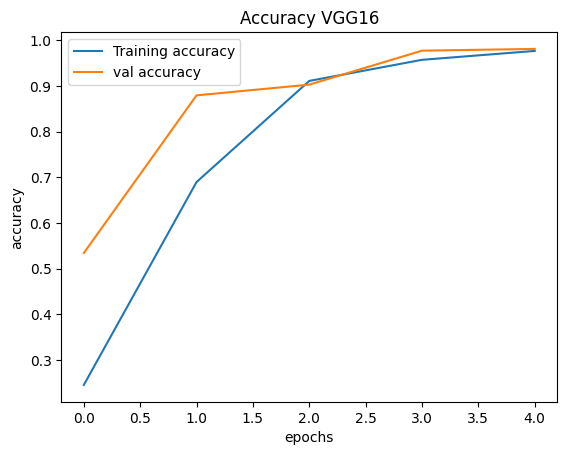

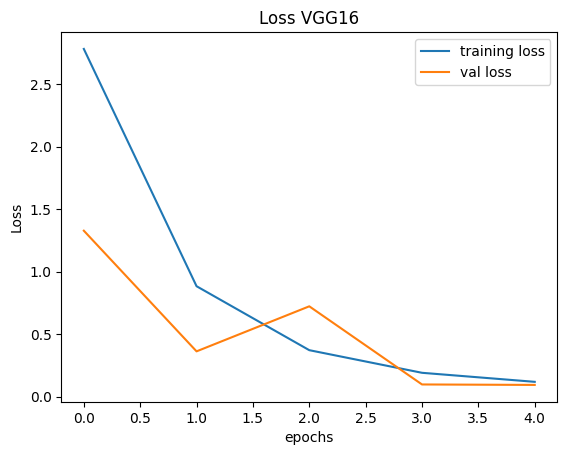

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="val accuracy")
plt.title("Accuracy VGG16")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure(1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.title("Loss VGG16")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Проверка точности модели на тестовой выборке и формирование итоговой таблицы

In [ ]:
loss, accuracy = model.evaluate(data, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

395/395 [==============================] - 5s 10ms/step - loss: 0.3001 - accuracy: 0.9432
Test loss: 0.30008652806282043
Test accuracy: 0.943230390548706


Точность модели VGG16 составляет 94%.

Сравнительная таблица:

| Модель   | Обучение | Валидация| Тест |
|----------|----------|----------|------|
| ResNet50 | loss: 0.0748 - accuracy: 0.9808  | val_loss: 0.0997 - val_accuracy: 0.9724  |Test loss: 0.3321272134780884 Test accuracy: 0.9229611754417419|
| VGG16    | loss: 0.1177 - accuracy: 0.9769 | val_loss: 0.0930 - val_accuracy: 0.9813  |Test loss: 0.30008652806282043 Test accuracy: 0.943230390548706|

# Задание 2

## ResNet50 FGSM.

Создание модели атаки, которая будет основываться на обученном классификаторе для внесения шума в изображение.
Для опрделенных `eps` выведено изображение после атаки и класс, предсказанный моделью.

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.4902576360702515
Adv Accuracy: 0.7570000290870667
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.00784313725490196
Adv Loss: 2.7190586557388308
Adv Accuracy: 0.6150000095367432
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.011764705882352941
Adv Loss: 3.7068427772521972
Adv Accuracy: 0.5120000243186951
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.01568627450980392
Adv Loss: 4.486612565994263
Adv Accuracy: 0.42100000381469727
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.0196078431372549
Adv Loss: 5.130580615997315
Adv Accuracy: 0.3529999852180481
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.03137254901960784
Adv Loss: 6.456913455963135
Adv Accuracy: 0.2160000056028366
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.0392156862745098
Adv Loss: 6.989834747314453
Adv Accuracy: 0.15600000321865082
True Loss: 0.3770858633518219
True 

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_rn50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_rn50", adv_accuracises_fgsm)
!cp adv_losses_fgsm_rn50.npy drive/MyDrive/adv_losses_pgd_rn50.npy
!cp adv_accuracises_fgsm_rn50.npy drive/MyDrive/adv_accuracises_fgsm_rn50.npy

Точность с `eps = 10/255 = 0,039..` равна 17%. С увелечением `eps` усиливается зашумление картинки, но следовательно и вероятность обнаружения атаки.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


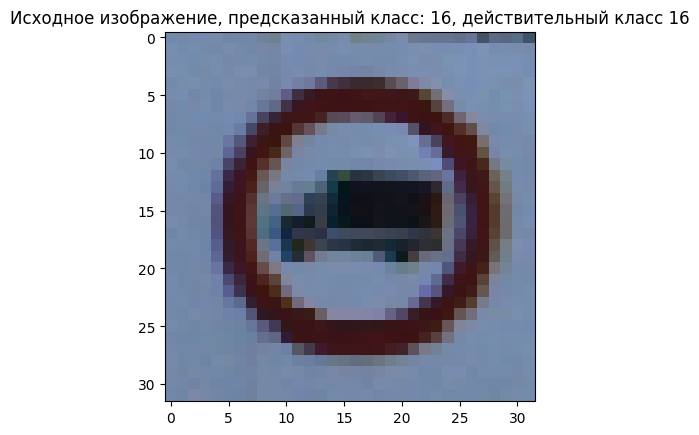

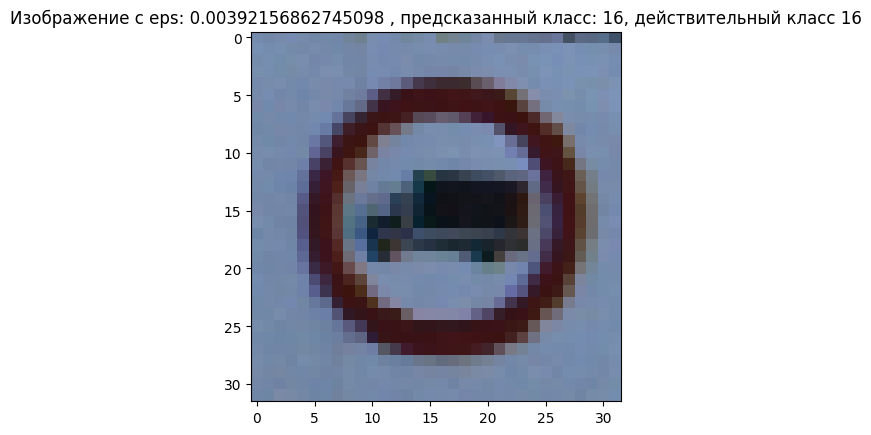

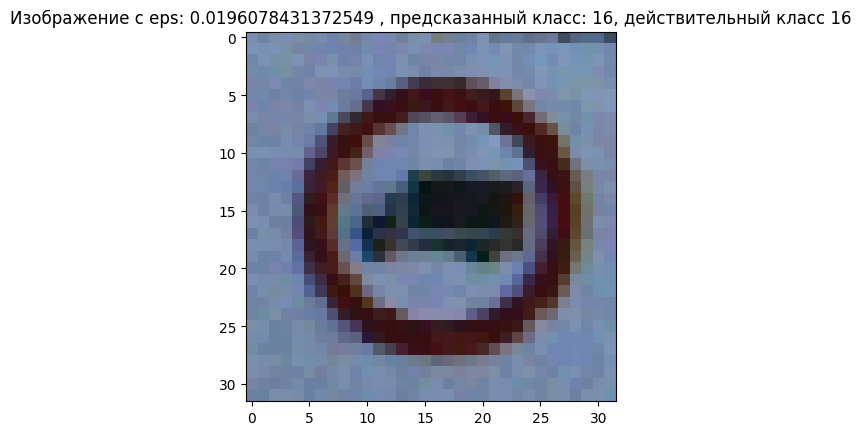

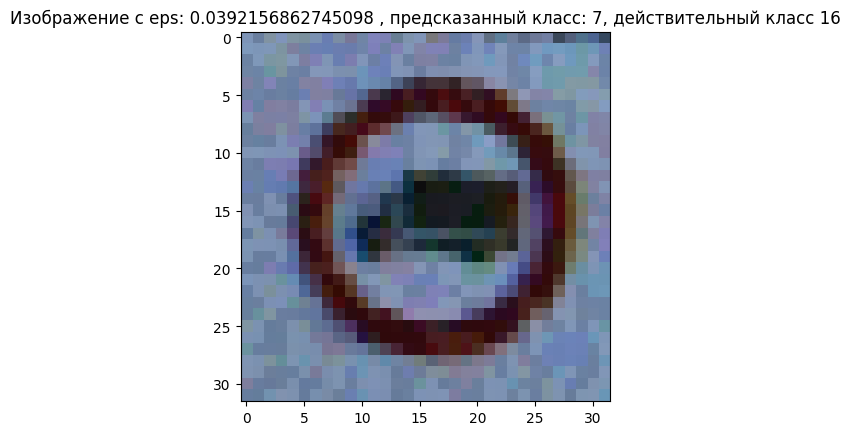

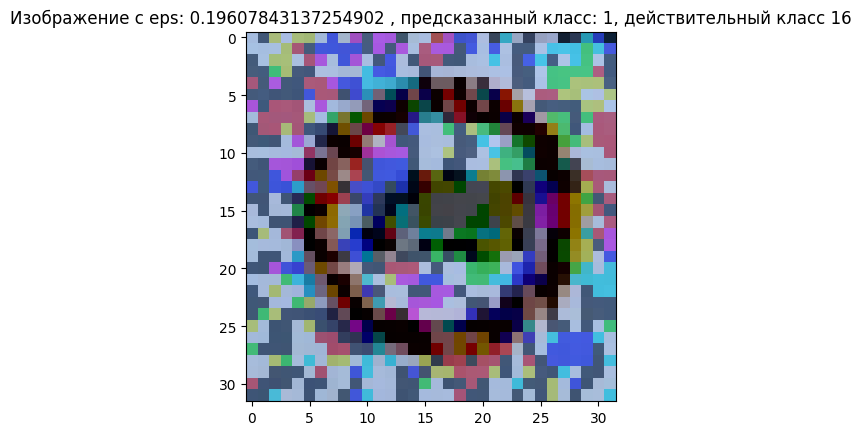

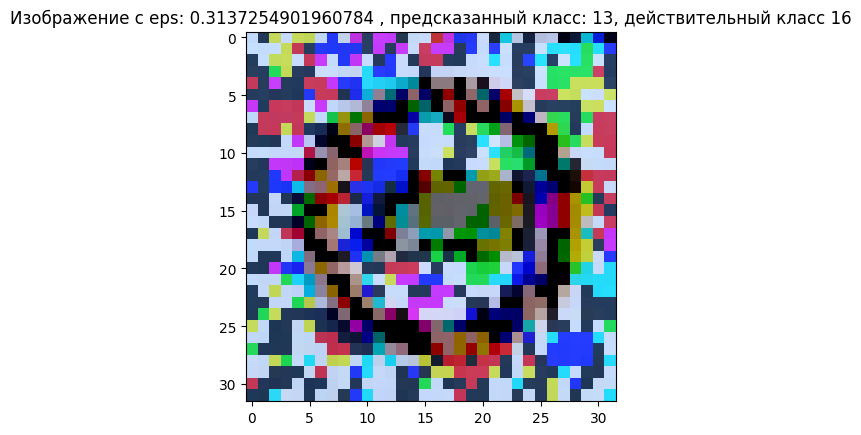

In [ ]:
eps_range = [1/255, 5/255, 10/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[0:1]))
plt.figure(0)
plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[0])}")
plt.imshow(x_test[0])
plt.show()
i = 1
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[0:1]))
    plt.figure(i)
    plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[0])}")
    plt.imshow(x_test_adv[0])
    plt.show()
    i += 1

Видно, что при росте `eps`, шум на картинке сильно увеличивается, и с `5/255` уже становится более заметен. Оптимальным `eps` будет значение от `5/255` до `10/255`

### ResNet50 PGD. Реализация атаки PGD для различных значений `eps`

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.7275916862487792
Adv Accuracy: 0.734000027179718
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.00784313725490196
Adv Loss: 3.4363997621536253
Adv Accuracy: 0.5609999895095825
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.011764705882352941
Adv Loss: 4.612672870635986
Adv Accuracy: 0.4560000002384186
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.01568627450980392
Adv Loss: 5.741621612548828
Adv Accuracy: 0.37700000405311584
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.0196078431372549
Adv Loss: 6.6994998779296875
Adv Accuracy: 0.32499998807907104
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.03137254901960784
Adv Loss: 7.913586990356445
Adv Accuracy: 0.23399999737739563
True Loss: 0.3770858633518219
True Accuracy: 0.9160000085830688
Eps: 0.0392156862745098
Adv Loss: 8.601851829528808
Adv Accuracy: 0.2029999941587448
True Loss:

Точность с `eps = 10/255 = 0,039..` равна 20%. С увеличением `eps` усиливается зашумление картинки, но следовательно и вероятность обнаружения атаки.

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_rn50", adv_losses_pgd)
np.save("adv_accuracises_pgd_rn50", adv_accuracises_pgd)
!cp adv_losses_pgd_rn50.npy drive/MyDrive/adv_losses_pgd_rn50.npy
!cp adv_accuracises_pgd_rn50.npy drive/MyDrive/adv_accuracises_pgd_rn50.npy

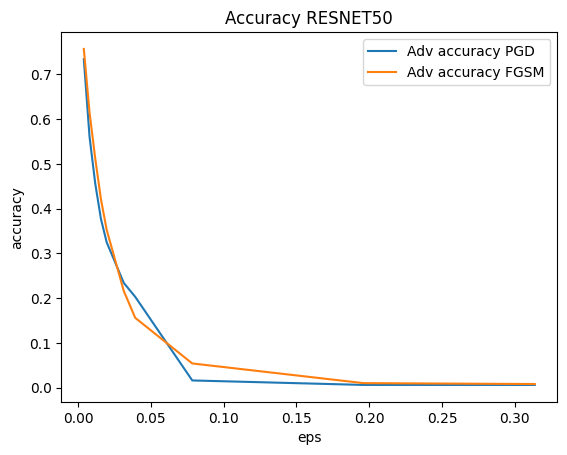

In [ ]:
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_rn50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_rn50.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD")
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM")
plt.title("Accuracy RESNET50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()

Из графиков видно, что методы имеют почти схожую эффективность, но метод PGD слегка больше снижает точность. Также видно, что самое большое снижение точности происходит в диапазоне от `0.05` до `0.08`. Далее точность снижается гораздо медленнее - следовательно значение `0.075` - наиболее эффективное значение для атаки.

## VGG16 FGSM

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.9301236559152604
Adv Accuracy: 0.8450000286102295
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.00784313725490196
Adv Loss: 1.6889885578155517
Adv Accuracy: 0.7279999852180481
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.011764705882352941
Adv Loss: 2.2991511178016664
Adv Accuracy: 0.6380000114440918
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.01568627450980392
Adv Loss: 2.8563100633621215
Adv Accuracy: 0.5649999976158142
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.0196078431372549
Adv Loss: 3.3920962495803835
Adv Accuracy: 0.48399999737739563
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.03137254901960784
Adv Loss: 4.4941282577514645
Adv Accuracy: 0.36000001430511475
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.0392156862745098
Adv Loss: 4.9852305583953855
Adv Accuracy: 0.2939999997615814
True L

Точность с `eps = 10/255 = 0,039..` равна 29%. С увелечением `eps` усиливается зашумление картинки, но следовательно и вероятность обнаружения атаки.

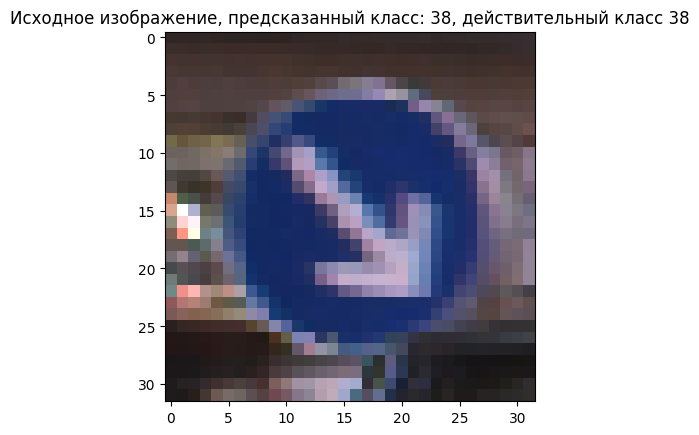

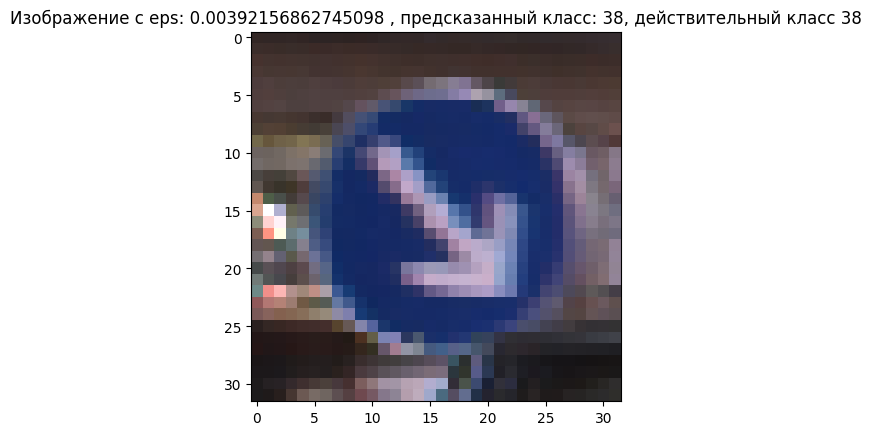

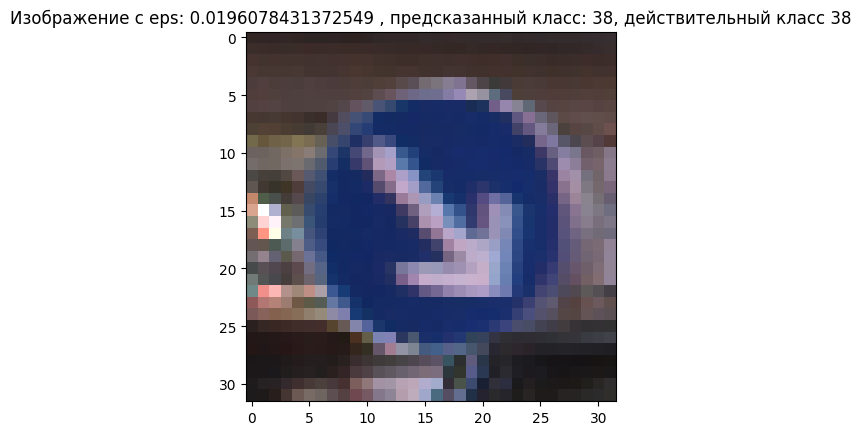

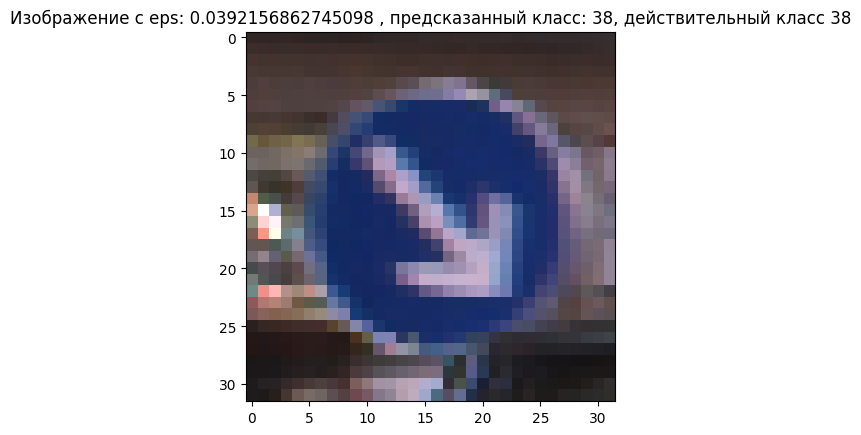

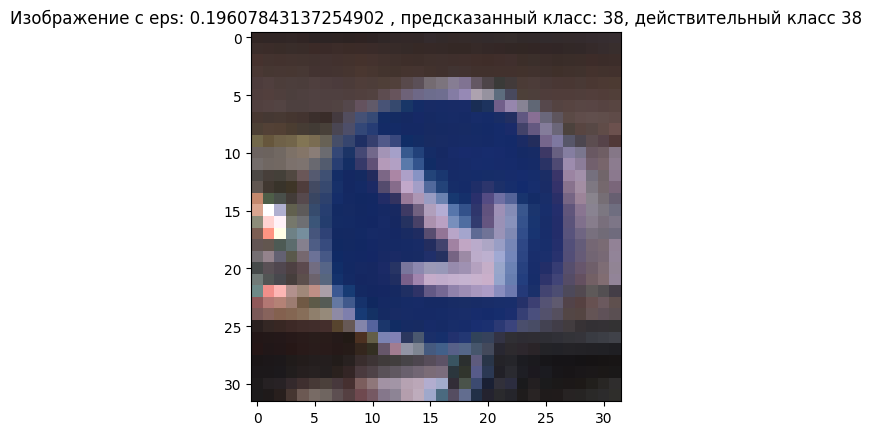

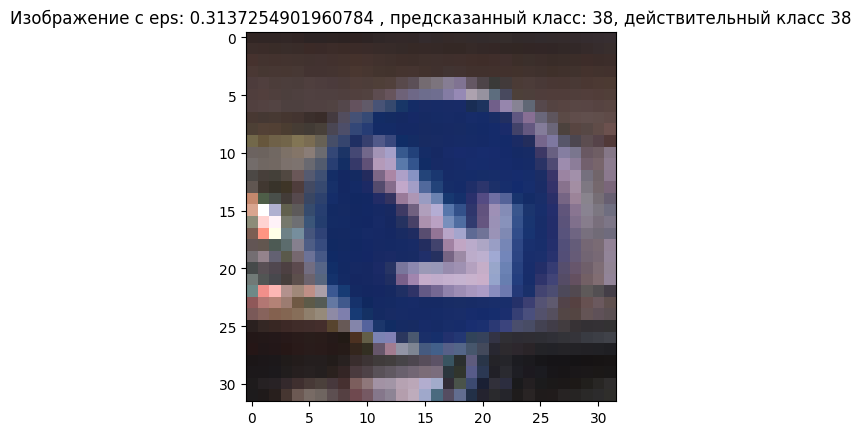

In [ ]:
eps_range = [1/255, 5/255, 10/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[2:3]))
plt.figure(0)
plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[2])}")
plt.imshow(x_test[2])
plt.show()
i = 1
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[2:3]))
    plt.figure(i)
    plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[2])}")
    plt.imshow(x_test_adv[2])
    plt.show()
    i += 1

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_vgg16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_vgg16", adv_accuracises_fgsm)
!cp adv_losses_fgsm_vgg16.npy drive/MyDrive/adv_losses_pgd_vgg16.npy
!cp adv_accuracises_fgsm_vgg16.npy drive/MyDrive/adv_accuracises_fgsm_vgg16.npy

## ResNet50 PGD

In [ ]:
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.0605025582313539
Adv Accuracy: 0.824999988079071
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.00784313725490196
Adv Loss: 2.1096783533096315
Adv Accuracy: 0.7289999723434448
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.011764705882352941
Adv Loss: 2.8860659487247466
Adv Accuracy: 0.6729999780654907
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.01568627450980392
Adv Loss: 3.924210683822632
Adv Accuracy: 0.5899999737739563
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.0196078431372549
Adv Loss: 4.6979598586559295
Adv Accuracy: 0.5270000100135803
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.03137254901960784
Adv Loss: 6.779891683578491
Adv Accuracy: 0.41999998688697815
True Loss: 0.24379921554215253
True Accuracy: 0.949999988079071
Eps: 0.0392156862745098
Adv Loss: 7.646722633361817
Adv Accuracy: 0.3880000114440918
True Loss: 

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_vgg16", adv_losses_pgd)
np.save("adv_accuracises_pgd_vgg16", adv_accuracises_pgd)
!cp adv_losses_pgd_vgg16.npy drive/MyDrive/adv_losses_pgd_vgg16.npy
!cp adv_accuracises_pgd_vgg16.npy drive/MyDrive/adv_accuracises_pgd_vgg16.npy

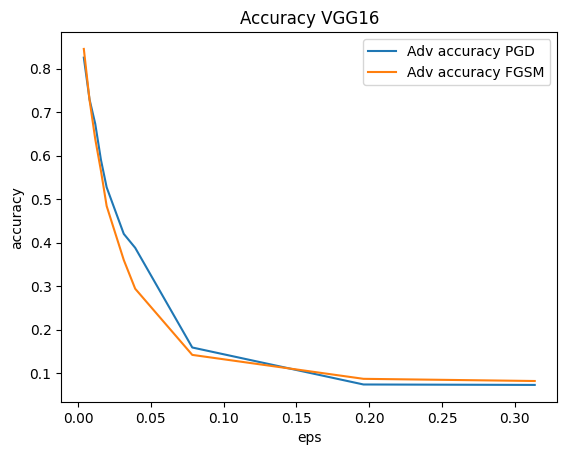

In [ ]:
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_vgg16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_vgg16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD")
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM")
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()

Результаты эксперимента с VGG16 такие же, как и с ResNet50

Заполним таблицу 2

| Модель   | Исходные изображения | Adversarial images 𝜖=1/255| Adversarial images 𝜖=5/255 | Adversarial images 𝜖=10/255|
|----------|----------|----------|------|------|
| ResNet50 - FGSM | 91% | 74% |33%|17%
| ResNet50 - PGD   |  91% | 71%  |30%|23%|
| VGG16 - FGSM | 89% | 79%  |44%|21%|
| VGG16 - PGD  | 89% | 77%  |48%|32%|


# Задание 3

### Targeted FGSM Attack

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1
for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [ ]:
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 0.9413439962599013
Adv Accuracy: 0.8111110925674438
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.00784313725490196
Adv Loss: 1.925759615721526
Adv Accuracy: 0.6629629731178284
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.011764705882352941
Adv Loss: 2.906994374593099
Adv Accuracy: 0.4703703820705414
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.01568627450980392
Adv Loss: 3.8209108917801466
Adv Accuracy: 0.34074074029922485
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.0196078431372549
Adv Loss: 4.557154316372341
Adv Accuracy: 0.192592591047287
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.03137254901960784
Adv Loss: 5.865696426674171
Adv Accuracy: 0.0555555559694767
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.0392156862745098
Adv Loss: 6.2929449328669795
Adv Accuracy: 0.03333333507180214
True Loss: 0.11108783673908976

In [ ]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

Выведем 5 примеров классификации класса 14 как класс 1 при помощи целевой FGSM атаки

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


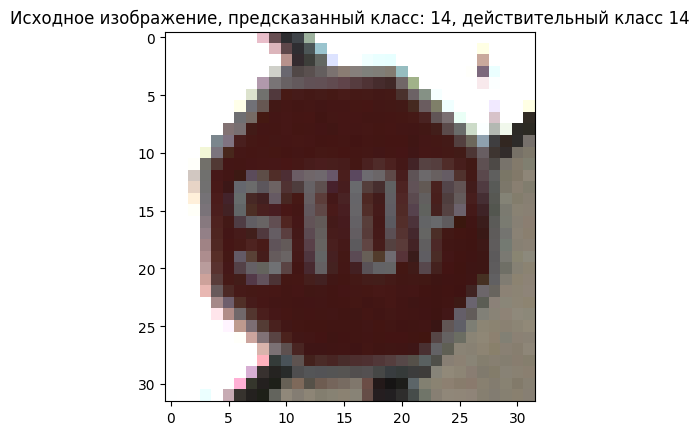

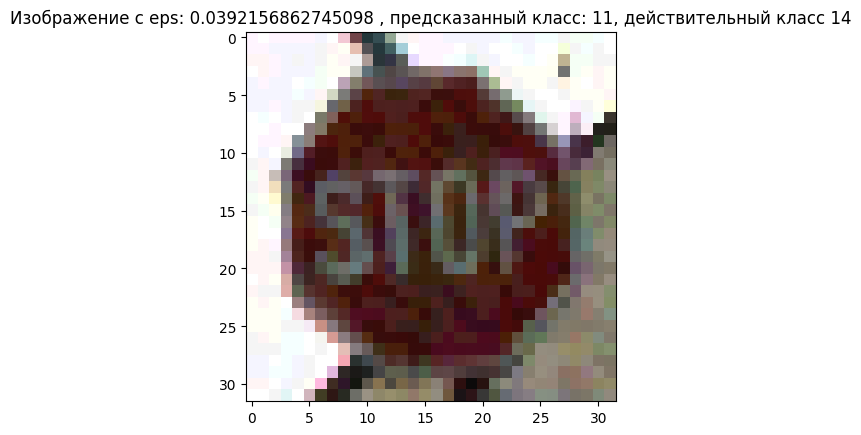

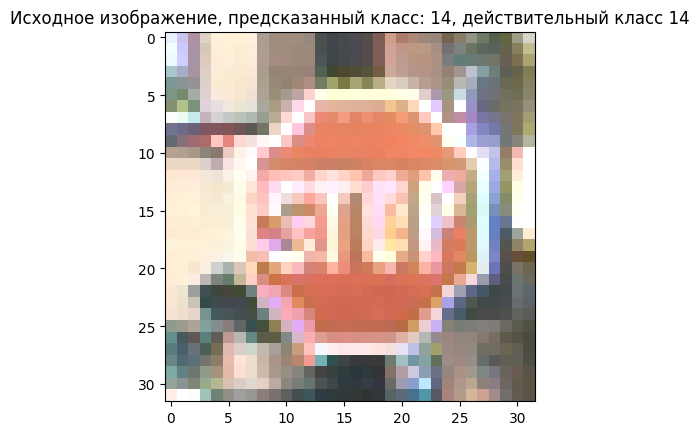

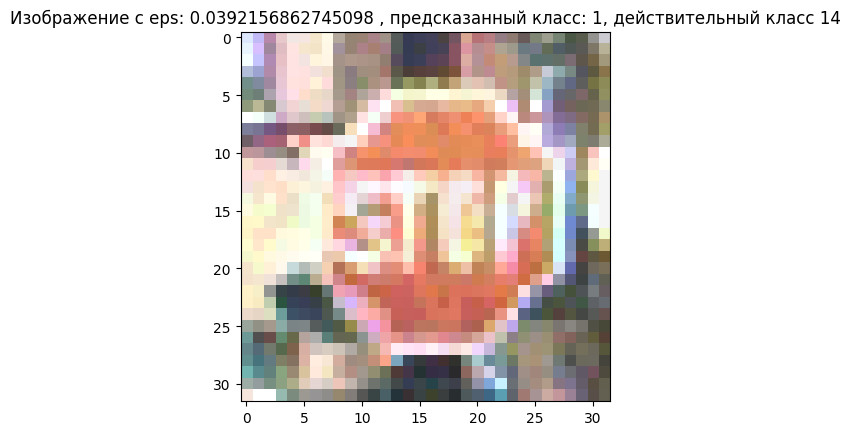

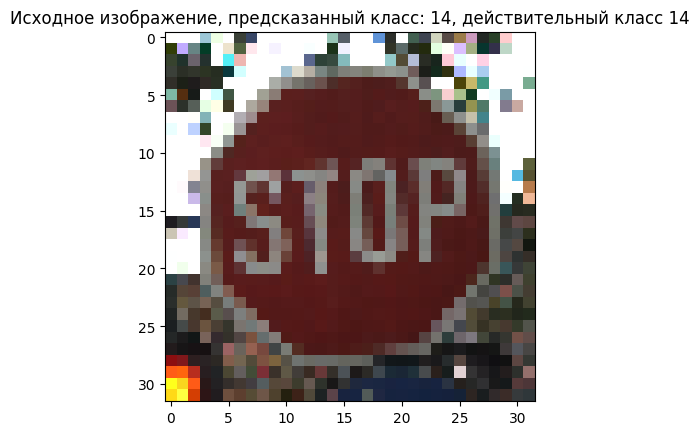

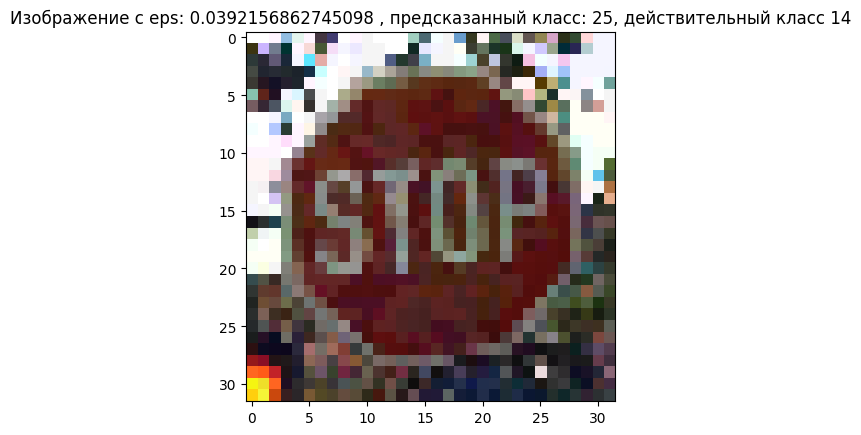

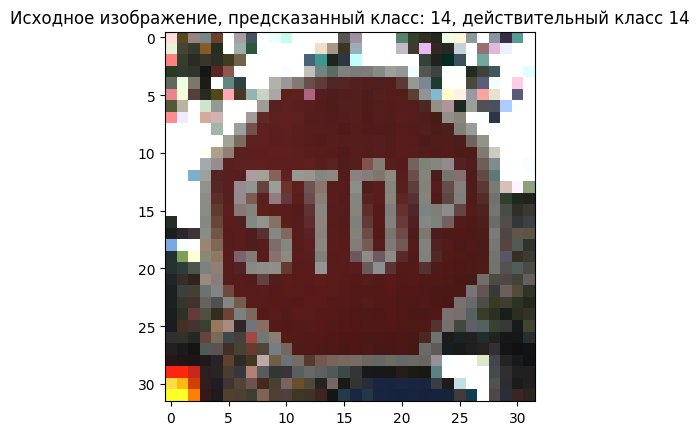

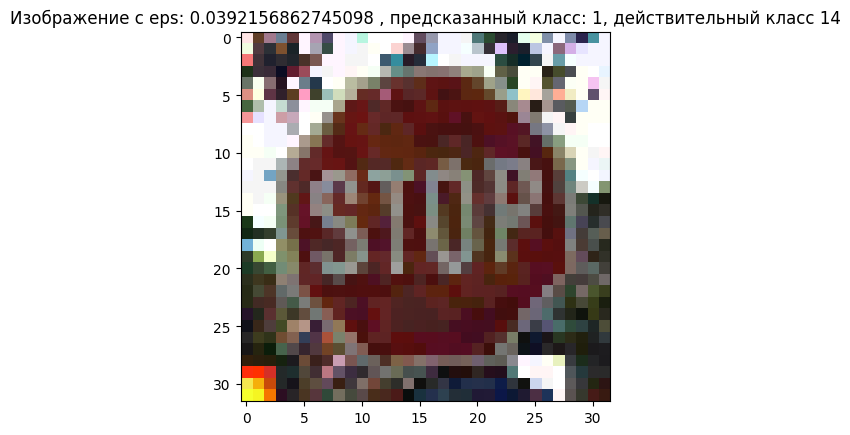

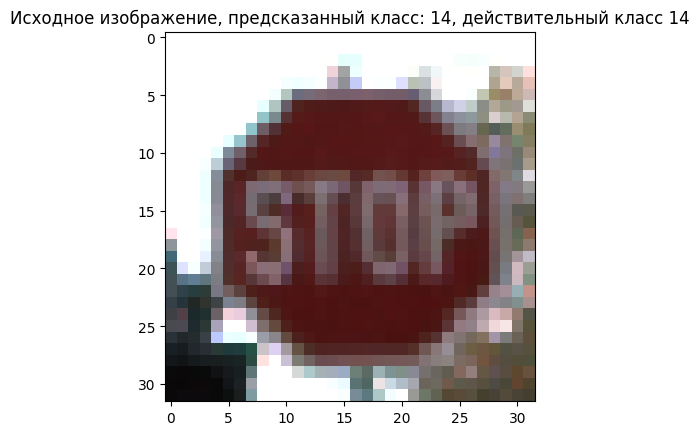

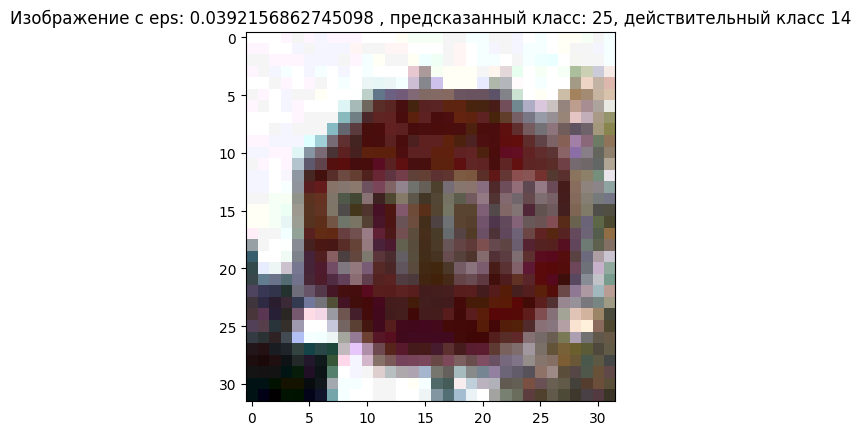

In [ ]:
range = [0, 3, 5, 6 , 8]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test_adv[index])
  plt.show()

### Targeted PGD Attack

In [ ]:
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.21736049343038488
Adv Accuracy: 0.9518518447875977
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.00784313725490196
Adv Loss: 0.6200162591757598
Adv Accuracy: 0.8740741014480591
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.011764705882352941
Adv Loss: 0.8546881437301636
Adv Accuracy: 0.7962962985038757
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.01568627450980392
Adv Loss: 1.3194304603117484
Adv Accuracy: 0.7333333492279053
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.0196078431372549
Adv Loss: 1.6931561028515851
Adv Accuracy: 0.6185185313224792
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.03137254901960784
Adv Loss: 2.4040465425561974
Adv Accuracy: 0.5592592358589172
True Loss: 0.11108783673908976
True Accuracy: 0.9777777791023254
Eps: 0.0392156862745098
Adv Loss: 2.7662452856699624
Adv Accuracy: 0.5370370149612427
T

In [ ]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

5 примеров классификации класса 14 как класс 1 при помощи целевой PGD атаки

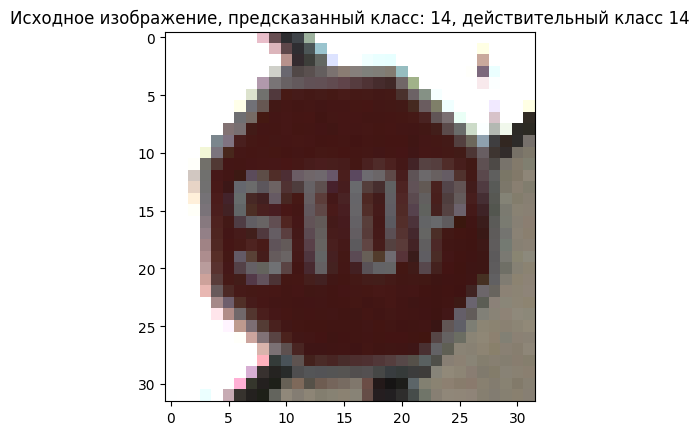

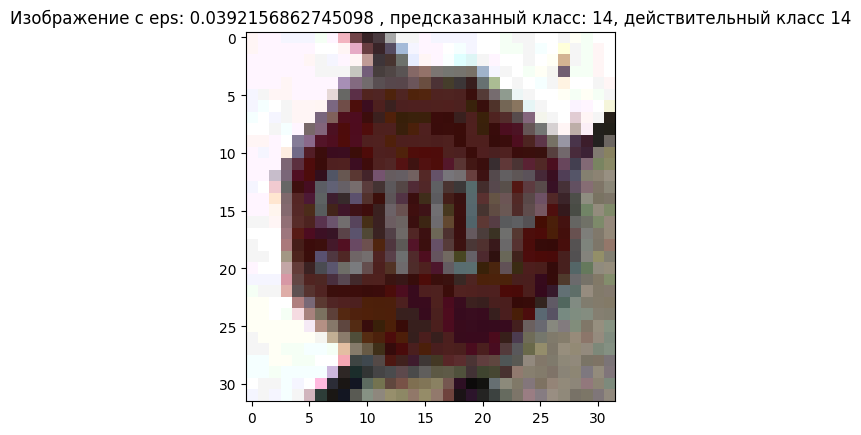

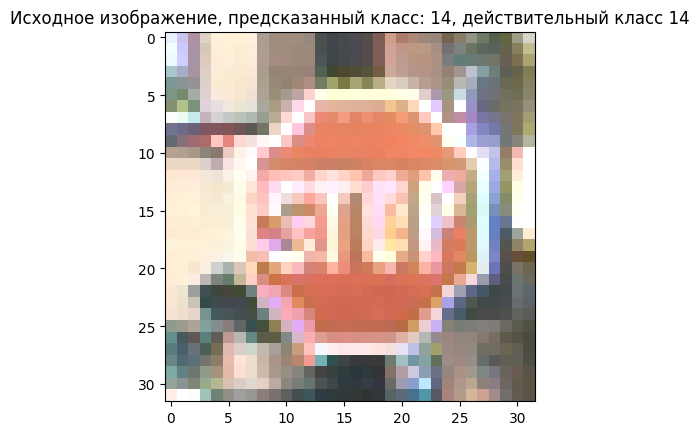

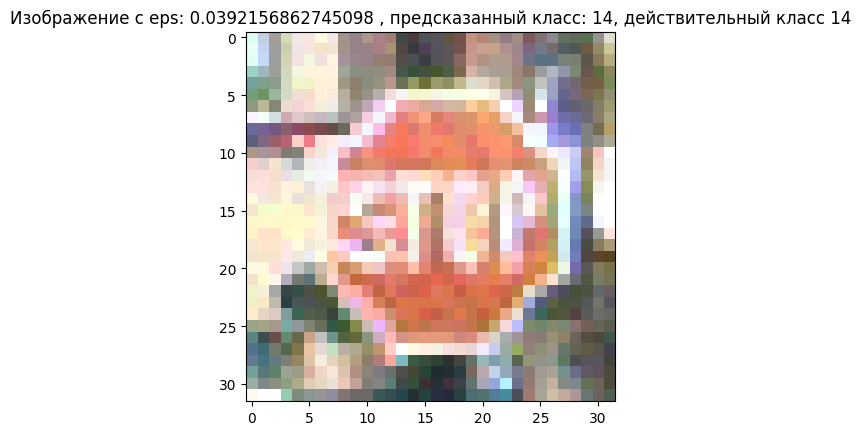

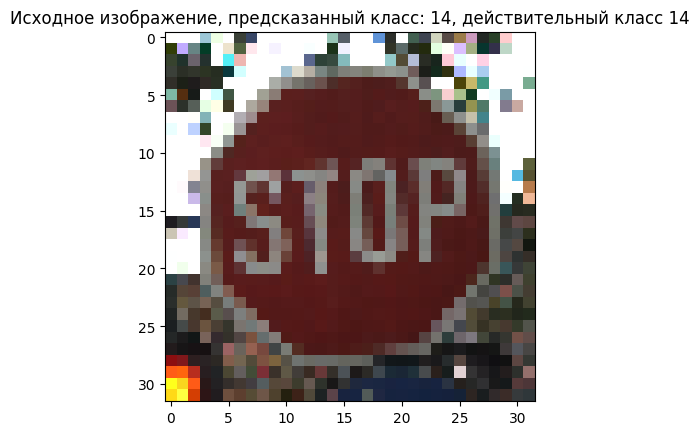

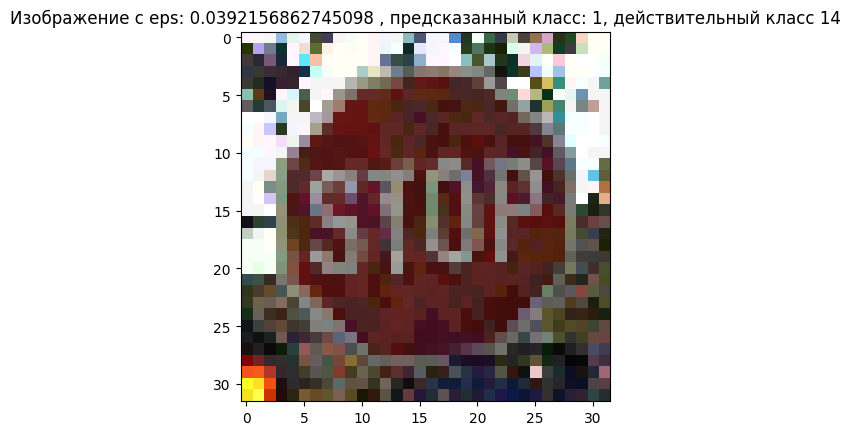

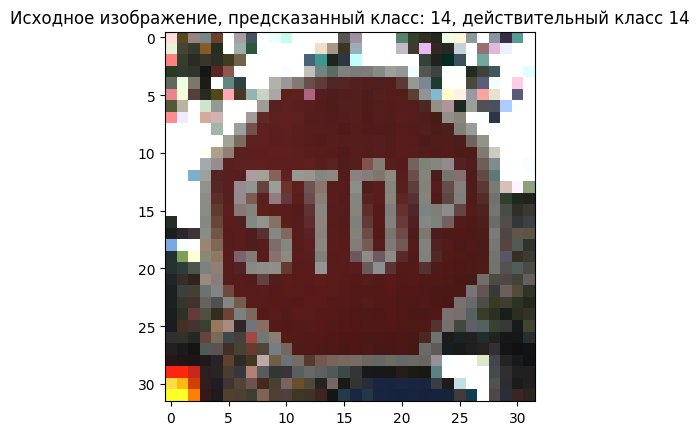

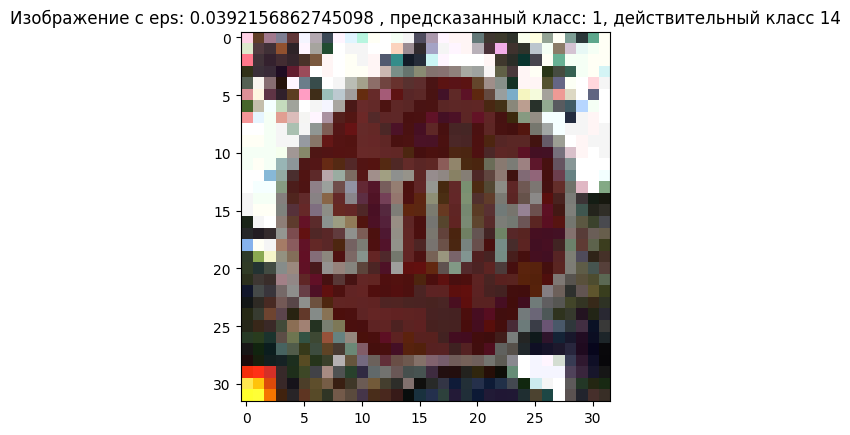

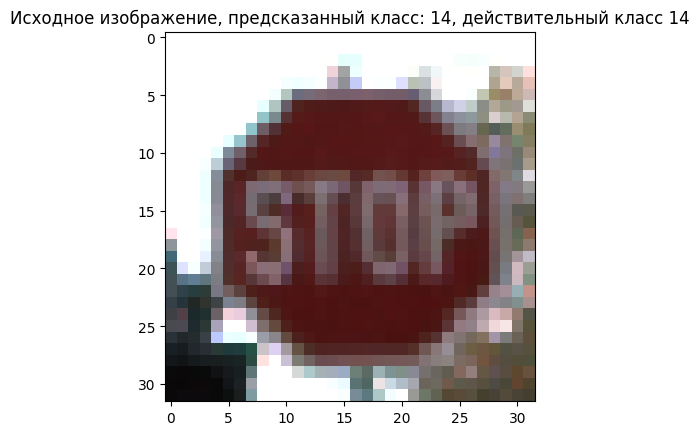

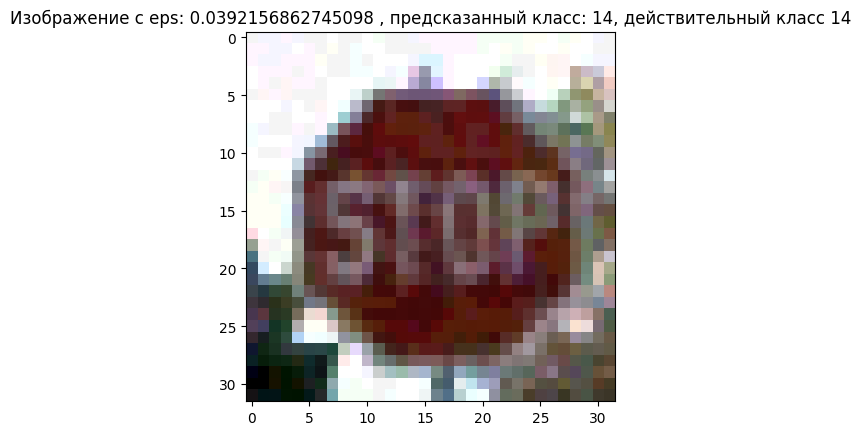

In [ ]:
range = [0, 3, 5, 6 , 8]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Исходное изображение, предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[index])}")
  plt.imshow(x_test_adv[index])
  plt.show()

Заполним итоговую таблицу точностей целевых атак PGD и FGSM на знак стоп (label 14), с цель классификации как Speed Limit 30 (label 1)


| Искажение  | PGD attack – Stop sign images | FGSM attack – Stop sign images|
|----------|----------|----------|
| 𝜖=1/255 | 99% | 100% |
| 𝜖=3/255 |  90% | 85%  |
| 𝜖=5/255 | 92% | 75%  |
| 𝜖=10/255 | 70% | 27%  |
| 𝜖=20/255 | 60% | 3%  |
| 𝜖=50/255 | 1% | 0%  |
| 𝜖=80/255 | 1% | 0%  |

Результат таков:
* метод FGSM для целевых атак применять не следует, с ростом eps и соответственно шума, классификация действительно ошибочна, однако класс который мы хотим навязать модели, наиболее точно определяется при `eps=10/255`, далее модель будет определять иные значения(не label 1).
* PGD отлично подходит для целевой атаки, при больших eps модель почти всегда будет определять класс 14 как 1, но изображение будет слишком зашумленным, для данной атаки оптимальным значением будет `50/255`, такие значения `eps` сильно зашумляют изображение, но и классификация класса 1 как класса 14 будет наиболее выраженной.

In [ ]:
eps = 50/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)
pred = model.predict(x_test_adv)
index = 0
for pr in pred:
  print(f"{index}: predicted: {np.argmax(pr)}")
  index +=1

0: predicted: 5
1: predicted: 1
2: predicted: 1
3: predicted: 1
4: predicted: 1
5: predicted: 1
6: predicted: 1
7: predicted: 1
8: predicted: 1
9: predicted: 2
10: predicted: 1
11: predicted: 1
12: predicted: 1
13: predicted: 20
14: predicted: 1
15: predicted: 18
16: predicted: 25
17: predicted: 1
18: predicted: 1
19: predicted: 1
20: predicted: 1
21: predicted: 5
22: predicted: 1
23: predicted: 1
24: predicted: 1
25: predicted: 1
26: predicted: 1
27: predicted: 1
28: predicted: 1
29: predicted: 25
30: predicted: 1
31: predicted: 1
32: predicted: 38
33: predicted: 1
34: predicted: 1
35: predicted: 1
36: predicted: 1
37: predicted: 1
38: predicted: 1
39: predicted: 1
40: predicted: 1
41: predicted: 1
42: predicted: 1
43: predicted: 1
44: predicted: 0
45: predicted: 1
46: predicted: 1
47: predicted: 1
48: predicted: 1
49: predicted: 1
50: predicted: 1
51: predicted: 1
52: predicted: 1
53: predicted: 1
54: predicted: 1
55: predicted: 1
56: predicted: 1
57: predicted: 1
58: predicted: 1
59

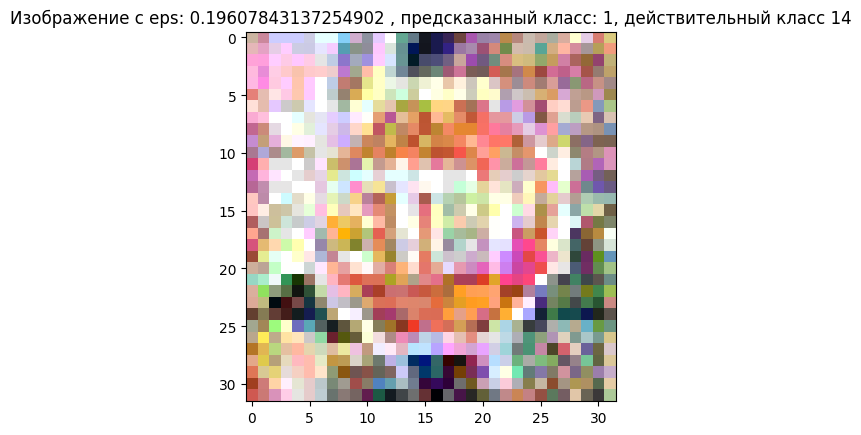

In [ ]:
pred = np.argmax(model.predict(x_test_adv[268:269]))
plt.figure(0)
plt.title(f"Изображение с eps: {eps} , предсказанный класс: {pred}, действительный класс {np.argmax(y_test[268])}")
plt.imshow(x_test_adv[268])
plt.show()